# Description

## Background:
* LA is famous for having diverse food options
* Different area of LA is known for different types of food
* For example:
    * Venice / Venice Beach area has a lot of food truck
    * Sawtelle has lots of Japanese food
    * Koreantwon has lots of Korean food

## Goal :
* Explore the food options of the different area of the 'downtown' LA

## Data:
* For each neighborhood, we need:
    * Zip Code
    * Neighborhood name
    * Longitude
    * Latitude
    * A list of the cusine the food venues in that area belongs to

# Importing Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 

import matplotlib.pyplot as plt 

import folium # map rendering library

from bs4 import BeautifulSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

print('Libraries imported.')

Libraries imported.


# Extracting table from websites

* I want to extract the zip code of the Los Angeles area along with the neighborhood names
* I found a list of zip code and the corresponding neighborhood names at <a href=http://www.laalmanac.com/employment/em12c.php>LA Almanac</a>
* I only want to look at the greater central Los Angeles neighborhoods and NOT other cities in Los Angeles County

In [2]:
URL = 'http://www.laalmanac.com/employment/em12c.php'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
table = soup.find_all('table')

table_list=[]

for data in soup.find_all('table'):
    for tr in data.find_all('tr'):
        row=[]
        for td in tr.find_all('td'):
            row.append(td.text.strip())
        table_list.append(row)

In [3]:
median_income = pd.DataFrame(table_list, columns = ['Zip Code', 'Community','Estimated Median Income']) 
median_income.drop([0],inplace=True)

In [4]:
median_income['Estimated Median Income']= median_income['Estimated Median Income'].str.strip('$')
median_income['Estimated Median Income']= median_income['Estimated Median Income'].str.replace(',','')

In [5]:
median_income.tail()

,Zip Code,Community,Estimated Median Income
280,93551,"City Ranch, Leona Valley, Palmdale",87628
281,93552,Palmdale,60612
282,93553,"Juniper Hills, Pearblossom",58105
283,93563,"Pearblossom, Valyermo",83875
284,93591,"Lake Los Angeles, Palmdale",44487


In [6]:
median_income = median_income.astype({'Zip Code': 'int32','Estimated Median Income': 'int32'})

* Since it is a table with all cities in Los Angeles County, I will filter out the other cities that is not in Los Angeles downtown area by only taking those community with the word Los Angeles in it

In [7]:
median_income.drop(median_income[~median_income.Community.str.contains("Los Angeles \(")].index,inplace=True)

* Take the words in parenthesis as a new column and drop the old community column

In [8]:
median_income['Neighborhood'] = median_income['Community'].str.extract(r'(\([\w ,-]+\))', expand=False)
median_income['Neighborhood'] = median_income['Neighborhood'].str.strip('()')
median_income.drop(['Community'],axis=1,inplace=True)
median_income.drop([''])

In [93]:
median_income.drop('Estimated Median Income',axis=1,inplace=True)
median_income.head()

,Zip Code,Neighborhood
1,90001,South Los Angeles
2,90002,"Southeast Los Angeles, Watts"
3,90003,"South Los Angeles, Southeast Los Angeles"
4,90004,"Hancock Park, Rampart Village, Virgil Village,..."
5,90005,"Hancock Park, Koreatown, Wilshire Center, Wils..."


* Getting a csv file with Califronia longitude and latitude from <a href='https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?refine.state=CA'>OpenDataSoft</a>

In [95]:
coord_path = 'CA-zip-code-latitude-and-longitude.csv'
coord = pd.read_csv(coord_path)

* Combing the two dataframes

In [96]:
la = median_income.merge(coord, how='inner',left_on='Zip Code',right_on='Zip')

In [97]:
la.drop(['Zip','Timezone','Daylight savings time flag','geopoint','State'],axis=1,inplace=True)

In [98]:
la.drop(la[la['Neighborhood'].isin(['Playa Vista','Harbor City','San Pedro, Terminal Island','San Pedro','Wilmington'])].index , inplace=True)

* Now we have generated the desired table with Zip Code, Neighborhood, Latitude, and Longitude

In [99]:
la.head()

,Zip Code,Neighborhood,City,Latitude,Longitude
0,90001,South Los Angeles,Los Angeles,33.972914,-118.24878
1,90002,"Southeast Los Angeles, Watts",Los Angeles,33.948315,-118.24845
2,90003,"South Los Angeles, Southeast Los Angeles",Los Angeles,33.962714,-118.27600
3,90004,"Hancock Park, Rampart Village, Virgil Village,...",Los Angeles,34.077110,-118.30755
4,90005,"Hancock Park, Koreatown, Wilshire Center, Wils...",Los Angeles,34.058911,-118.30848


# Generating a map to visuallize the neighborhood

In [15]:
# Los Angeles downtown coordinate
latitude = 34.061611
longitude = -118.242550

In [16]:
# create map of LA using latitude and longitude values
map_la = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(la['Latitude'], la['Longitude'], la['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
map_la

In [17]:
la.shape

(97, 6)

# Getting venues information from FourSquare API

* only want to get food venus

In [18]:
CLIENT_ID = 'ISSTQAGE3UXGU0RN1W1QDE4MUQ144YR03WRHUA5ODQKY3R53'
CLIENT_SECRET = 'TGCXSXBOBXUBXYUXSUT4XQCWNZI1ZK4BQI4KGMUXNMKVDBW3'
radius = 500
LIMIT = 100
VERSION = "20180323"
categoryId='4d4b7105d754a06374d81259'

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            categoryId,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
"""
names = ['South Los Angeles','Southeast Los Angeles','Sawtelle']
lat= [33.972914,33.948315,34.045006]
long=[-118.24878,-118.24845,-118.44527]

test_food_venues = getNearbyVenues(names=names,
                                   latitudes=lat,
                                   longitudes=long, radius = radius
                                  )

test_food_venues.head()
"""

"\nnames = ['South Los Angeles','Southeast Los Angeles','Sawtelle']\nlat= [33.972914,33.948315,34.045006]\nlong=[-118.24878,-118.24845,-118.44527]\n\ntest_food_venues = getNearbyVenues(names=names,\n                                   latitudes=lat,\n                                   longitudes=long, radius = radius\n                                  )\n\ntest_food_venues.head()\n"

In [21]:
la_food_venues = getNearbyVenues(names=la['Neighborhood'],
                                   latitudes=la['Latitude'],
                                   longitudes=la['Longitude'], radius = radius
                                  )

South Los Angeles
Southeast Los Angeles, Watts
South Los Angeles, Southeast Los Angeles
Hancock Park, Rampart Village, Virgil Village, Wilshire Center, Windsor Square
Hancock Park, Koreatown, Wilshire Center, Wilshire Park, Windsor Square
Byzantine-Latino Quarter, Harvard Heights, Koreatown, Pico Heights
Southeast Los Angeles, Univerity Park
Baldwin Hills, Crenshaw, Leimert Park
Hancock Park, Wilshire Center, Windsor Square
Southeast Los Angeles
Downtown Civic Center, Chinatown, Arts District, Bunker Hill, Historic Core, Little Tokyo
Downtown Central, Downtown Fashion District
Downtown Historic Core, Arts District
Dowtown Fashion District, South Park-South
West Adams
Downtown Bunker Hill, City West, South Park-North
Jefferson Park, Leimert Park
Arlington Heights, Country Club Park, Mid-City
Hancock Park, Western Wilton, Wilshire Center, Windsor Square
Downtown Fashion District, Downtown Southeast
Westwood
Sawtelle, West Los Angeles
Echo Park, Silver Lake
Griffith Park, Hollywood, Los F

# Combing through the categories to combine the food categories

In [22]:
#la_food_venues['Venue Category'].unique()
# we want to combine certain categories - for example, combing sushi, ramen into Japanese, combing Cantonese, Taiwanese into Chiense, etc

In [23]:
fast_food = ['Fast Food Restaurant','Burger Joint','Sandwich Place','Fish & Chips Shop','Pizza Place', 'Donut Shop','Snack Place','Salad Place','Deli / Bodega','Cafeteria','Hot Dog Joint','Soup Place','Bagel Shop']
american = ['American Restaurant','Wings Joint','Fried Chicken Joint','Southern / Soul Food Restaurant','Comfort Food Restaurant','New American Restaurant']
hawaii = ['Hawaiian Restaurant','Poke Place']
japanese = ['Japanese Restaurant','Donburi Restaurant','Donburi Bowl','Ramen Restaurant','Sushi Restaurant']
chinese = ['Chinese Restaurant','Dumpling Restaurant','Taiwanese Restaurant','Dim Sum Restaurant','Cantonese Restaurant','Szechuan Restaurant']
mexican = ['Mexican Restaurant','Taco Place','Burrito Place']
middle_eastern = ['Middle Eastern Restaurant','Eastern European Restaurant','Greek Restaurant','Lebanese Restaurant','Doner Restaurant','Satay Restaurant','Kebab Restaurant'] 
spanish = ['Spanish Restaurant','Tapas Restaurant']
indian = ['Indian Restaurant','North Indian Restaurant']
french= ['French Restaurant','Creperie']
pub =['pub','Irish Pub','Gastropub']
african=['African Restaurant','Ethiopian Restaurant','Moroccan Restaurant']
kosher=['Kosher Restaurant','Jewish Restaurant','Halal Restaurant']
asian=['Asian Restaurant','Noodle House']
latin_america = ['Latin American Restaurant','Cuban Restaurant','South American Restaurant','Caribbean Restaurant','Peruvian Restaurant','Brazilian Restaurant','Argentinian Restaurant']

In [24]:
def change_category(df,category_list):
    changed_to = category_list[0]
    df['General Category'][df[df['Venue Category'].isin(category_list)].index] = changed_to
    return df

In [25]:
la_food_venues['General Category']=la_food_venues['Venue Category']
la_food_venues = change_category(la_food_venues,fast_food)
la_food_venues = change_category(la_food_venues,american)
la_food_venues = change_category(la_food_venues,hawaii)
la_food_venues = change_category(la_food_venues,japanese)
la_food_venues = change_category(la_food_venues,chinese)
la_food_venues = change_category(la_food_venues,mexican)
la_food_venues = change_category(la_food_venues,middle_eastern)
la_food_venues = change_category(la_food_venues,french)
la_food_venues = change_category(la_food_venues,pub)
la_food_venues = change_category(la_food_venues,kosher)
la_food_venues = change_category(la_food_venues,spanish)
la_food_venues = change_category(la_food_venues,indian)
la_food_venues = change_category(la_food_venues,asian)
la_food_venues = change_category(la_food_venues,african)
la_food_venues = change_category(la_food_venues,asian)
la_food_venues = change_category(la_food_venues,latin_america)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
la_food_venues.drop(la_food_venues[la_food_venues['Venue Category'].isin(['Food','Restaurant'])].index,inplace=True)

In [27]:
la_food_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Category
0,South Los Angeles,33.972914,-118.24878,Bill's Drive In,33.974500,-118.244225,Burger Joint,Fast Food Restaurant
1,South Los Angeles,33.972914,-118.24878,SUBWAY,33.975386,-118.248062,Sandwich Place,Fast Food Restaurant
2,South Los Angeles,33.972914,-118.24878,Jack in the Box,33.975167,-118.250313,Fast Food Restaurant,Fast Food Restaurant
3,South Los Angeles,33.972914,-118.24878,Pizza Hut,33.975231,-118.248249,Pizza Place,Fast Food Restaurant
4,South Los Angeles,33.972914,-118.24878,WINCHELL'S DONUT HOUSE,33.975075,-118.248211,Donut Shop,Fast Food Restaurant


In [28]:
la_food_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Category
Neighborhood,,,,,,,
"Arleta, Hansen Hills, Pacoima",3,3,3,3,3,3,3
"Arlington Heights, Country Club Park, Mid-City",19,19,19,19,19,19,19
"Atwater Village, Elysian Valley, Silver Lake",1,1,1,1,1,1,1
"Baldwin Hills, Crenshaw, Leimert Park",27,27,27,27,27,27,27
"Bel Air Estates, Beverly Glen",2,2,2,2,2,2,2
"Bel Air Estates, Brentwood",1,1,1,1,1,1,1
Boyle Heights,15,15,15,15,15,15,15
"Byzantine-Latino Quarter, Harvard Heights, Koreatown, Pico Heights",12,12,12,12,12,12,12
Canoga Park,13,13,13,13,13,13,13


In [29]:
print('There are {} uniques categories.'.format(len(la_food_venues['General Category'].unique())))

There are 38 uniques categories.


In [30]:
la_food_venues['General Category'].unique()

array(['Fast Food Restaurant', 'Mexican Restaurant',
       'American Restaurant', 'Japanese Restaurant', 'Asian Restaurant',
       'Bakery', 'Seafood Restaurant', 'Chinese Restaurant',
       'Thai Restaurant', 'Korean Restaurant', 'Café',
       'Vietnamese Restaurant', 'Latin American Restaurant',
       'Italian Restaurant', 'Food Court', 'Diner', 'Spanish Restaurant',
       'Food Truck', 'Mediterranean Restaurant', 'pub',
       'Hawaiian Restaurant', 'Indian Restaurant', 'Breakfast Spot',
       'Vegetarian / Vegan Restaurant', 'Cajun / Creole Restaurant',
       'Filipino Restaurant', 'BBQ Joint', 'French Restaurant',
       'Middle Eastern Restaurant', 'Food Stand', 'Steakhouse',
       'Kosher Restaurant', 'Theme Restaurant', 'Buffet',
       'German Restaurant', 'Afghan Restaurant', 'African Restaurant',
       'Bistro'], dtype=object)

In [31]:
mask = (la_food_venues['General Category'].value_counts()<=2)
mask_col_name = la_food_venues['General Category'].value_counts()[mask].index
mask_col_name

Index(['Cajun / Creole Restaurant', 'Food Stand', 'Bistro',
       'African Restaurant', 'Buffet', 'Afghan Restaurant', 'Theme Restaurant',
       'German Restaurant'],
      dtype='object')

In [32]:
# dropping the low occuring cateogories and drop fast food since it doesn't represent a cusisine
la_food_venues.drop(la_food_venues[la_food_venues['General Category'].isin(mask_col_name)].index,inplace=True)
la_food_venues.drop(la_food_venues[la_food_venues['General Category']=='Fast Food Restaurant'].index,inplace=True)

# Preprocessing for clustering : One hot encoding

In [33]:
# one hot encoding
la_food_onehot = pd.get_dummies(la_food_venues[['General Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_food_onehot['Neighborhood'] = la_food_venues['Neighborhood'] 

Neighborhood = la_food_onehot['Neighborhood']
la_food_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
la_food_onehot.insert(0, 'Neighborhood', Neighborhood)

la_food_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Breakfast Spot,Café,Chinese Restaurant,Diner,Filipino Restaurant,Food Court,Food Truck,French Restaurant,Hawaiian Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Seafood Restaurant,Spanish Restaurant,Steakhouse,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,pub
5,South Los Angeles,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,South Los Angeles,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,"South Los Angeles, Southeast Los Angeles",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,"South Los Angeles, Southeast Los Angeles",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
19,"Hancock Park, Rampart Village, Virgil Village,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
la_food_grouped = la_food_onehot.groupby('Neighborhood').mean().reset_index()

* Drop Neighborhoods where there are less than or equal to 5 venues

In [35]:
#la_food_onehot.groupby('Neighborhood').count()

In [36]:
lt = la_food_onehot.groupby('Neighborhood').count()<=5
lt = lt.reset_index()

In [37]:
print("less than 5 dataframe shape:",lt.shape)
print("la food grouped dataframe sahpe:",la_food_grouped.shape)

less than 5 dataframe shape: (76, 30)
la food grouped dataframe sahpe: (76, 30)


In [38]:
# This just drop any count below 5 
la_food_grouped.drop(lt[lt['American Restaurant']==True].index, inplace=True)

In [42]:
la_food_grouped.shape

(53, 30)

# Looking at the top neighborhood for certain food and the top cusine in each neighborhood

In [92]:
la_most = la_food_grouped.set_index('Neighborhood')
la_best = la_most.max(axis=0).to_frame(name='highest percentage in neighborhood')
la_best['highest percentage in neighborhood'] = (la_best['highest percentage in neighborhood']*100).round(1)
la_best['best neighborhood'] = la_most.idxmax(axis=0).to_frame()
la_best

,highest percentage in neighborhood,best neighborhood
American Restaurant,54.5,"Hyde Park, View Park, Windsor Hills"
Asian Restaurant,28.6,Panorama City
BBQ Joint,33.3,Granada Hills
Bakery,50.0,Granada Hills
Breakfast Spot,10.0,"Lake View Terrace, Sylmar"
Café,33.3,"Fairfax, Melrose, Miracle Mile, Park La Brea, ..."
Chinese Restaurant,33.3,"Downtown Civic Center, Chinatown, Arts Distric..."
Diner,14.3,Southeast Los Angeles
Filipino Restaurant,42.9,Panorama City
Food Court,11.1,"Downtown Fashion District, Downtown Southeast"


In [65]:
num_top_venues = 5

for hood in la_food_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = la_food_grouped[la_food_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arlington Heights, Country Club Park, Mid-City----
                 venue  freq
0   Mexican Restaurant  0.31
1   Chinese Restaurant  0.23
2  American Restaurant  0.15
3    Kosher Restaurant  0.08
4  Japanese Restaurant  0.08


----Baldwin Hills, Crenshaw, Leimert Park----
                 venue  freq
0  American Restaurant   0.4
1   Chinese Restaurant   0.1
2   Seafood Restaurant   0.1
3   Mexican Restaurant   0.1
4    Indian Restaurant   0.1


----Boyle Heights----
                venue  freq
0  Mexican Restaurant   0.5
1          Food Truck   0.2
2              Bakery   0.1
3     Thai Restaurant   0.1
4  Seafood Restaurant   0.1


----Byzantine-Latino Quarter, Harvard Heights, Koreatown, Pico Heights----
                       venue  freq
0          Korean Restaurant  0.33
1  Latin American Restaurant  0.22
2                     Bakery  0.11
3                      Diner  0.11
4         Spanish Restaurant  0.11


----Canoga Park----
                 venue  freq
0  American Restaur

                       venue  freq
0         Mexican Restaurant  0.38
1        American Restaurant  0.19
2  Latin American Restaurant  0.12
3                     Bakery  0.06
4            Thai Restaurant  0.06


----Northridge----
                 venue  freq
0  American Restaurant  0.17
1   Mexican Restaurant  0.17
2   Chinese Restaurant  0.08
3  Japanese Restaurant  0.08
4           Food Court  0.08


----Panorama City----
                 venue  freq
0  Filipino Restaurant  0.43
1     Asian Restaurant  0.29
2                 Café  0.14
3   Seafood Restaurant  0.14
4  American Restaurant  0.00


----Reseda----
                       venue  freq
0      Vietnamese Restaurant  0.33
1            Thai Restaurant  0.11
2         Chinese Restaurant  0.11
3         Seafood Restaurant  0.11
4  Middle Eastern Restaurant  0.11


----Sawtelle, West Los Angeles----
                       venue  freq
0        Japanese Restaurant  0.39
1  Middle Eastern Restaurant  0.13
2         Chinese Restaurant

# A table with the 5 most common cuising in each neighborhood

In [66]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = la_food_grouped['Neighborhood']

for ind in np.arange(la_food_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(la_food_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,"Arlington Heights, Country Club Park, Mid-City",Mexican Restaurant,Chinese Restaurant,American Restaurant,BBQ Joint,Japanese Restaurant
3,"Baldwin Hills, Crenshaw, Leimert Park",American Restaurant,Asian Restaurant,Seafood Restaurant,Mexican Restaurant,Chinese Restaurant
5,Boyle Heights,Mexican Restaurant,Food Truck,Thai Restaurant,Bakery,Seafood Restaurant
6,"Byzantine-Latino Quarter, Harvard Heights, Kor...",Korean Restaurant,Latin American Restaurant,Bakery,Spanish Restaurant,Diner
7,Canoga Park,American Restaurant,Mexican Restaurant,Asian Restaurant,Bakery,Café


# K-means Clustering

In [67]:
# do not want to use the neighborhood label in the clustering
la_food_grouped_clustering = la_food_grouped.drop('Neighborhood', 1)

* Picking the best k

In [68]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,15) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(la_food_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(la_food_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / la_food_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(la_food_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / la_food_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    

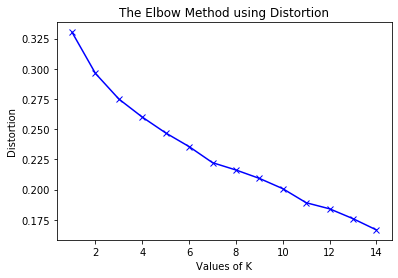

In [69]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

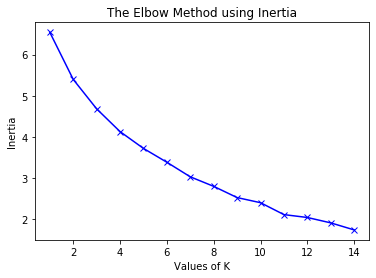

In [70]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

* Elbow method does not yield a answer so use my intuition to pick the number of k
* I picked 7 clusters at the end because:
    * trying different values and looking at the classificaiton, 7 yields the most meaningful results
    * each of the 7 labels has different characteristics:
        * Food Truck
        * American
        * Mexican
        * Japanese
        * Korean
        * Misc
        * A little bit of everything

In [71]:
# set number of clusters
kclusters = 7

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_food_grouped_clustering)

In [72]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [73]:
# merge grouped with data to add latitude/longitude for each neighborhood
la_merged = la.merge(neighborhoods_venues_sorted,on='Neighborhood',how='inner')

In [74]:
la_merged.drop_duplicates(['Neighborhood'],keep='first',inplace=True)

In [75]:
la_merged.shape

(53, 12)

# Looking at each culster individually

In [76]:
la_merged.loc[la_merged['Cluster Labels'] == 0]

,Zip Code,Estimated Median Income,Neighborhood,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
14,90012,38786,"Downtown Civic Center, Chinatown, Arts Distric...",Los Angeles,34.061611,-118.23944,0,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Bakery,Asian Restaurant
23,90026,54342,"Echo Park, Silver Lake",Los Angeles,34.078510,-118.26596,0,Food Truck,Café,Mexican Restaurant,Thai Restaurant,Asian Restaurant
29,90029,37379,East Hollywood,Los Angeles,34.090259,-118.29455,0,Bakery,Asian Restaurant,Mexican Restaurant,American Restaurant,Middle Eastern Restaurant
33,90035,76677,West Fairfax,Los Angeles,34.052660,-118.38531,0,Kosher Restaurant,Middle Eastern Restaurant,Italian Restaurant,Bakery,Japanese Restaurant
34,90036,74279,"Fairfax, Melrose, Miracle Mile, Park La Brea, ...",Los Angeles,34.070360,-118.34926,0,Café,Thai Restaurant,Bakery,Chinese Restaurant,Food Truck
35,90041,73250,Eagle Rock,Los Angeles,34.137557,-118.20765,0,Italian Restaurant,Thai Restaurant,Asian Restaurant,Mexican Restaurant,French Restaurant
39,90048,85396,Mid-City West,Los Angeles,34.073759,-118.37376,0,Seafood Restaurant,Mexican Restaurant,Chinese Restaurant,Café,Middle Eastern Restaurant
52,91335,55580,Reseda,Reseda,34.200104,-118.54099,0,Vietnamese Restaurant,Mexican Restaurant,Chinese Restaurant,Asian Restaurant,Thai Restaurant
55,91344,86460,Granada Hills,Granada Hills,34.277648,-118.50047,0,Bakery,BBQ Joint,Middle Eastern Restaurant,pub,Indian Restaurant
56,91402,41669,Panorama City,Panorama City,34.223753,-118.44322,0,Filipino Restaurant,Asian Restaurant,Seafood Restaurant,Café,pub


In [77]:
la_merged.loc[la_merged['Cluster Labels'] == 1]

,Zip Code,Estimated Median Income,Neighborhood,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,90007,23070,"Southeast Los Angeles, Univerity Park",Los Angeles,34.026448,-118.28290,1,Italian Restaurant,Food Truck,American Restaurant,Hawaiian Restaurant,Latin American Restaurant
12,90011,33824,Southeast Los Angeles,Los Angeles,34.007063,-118.25868,1,Mexican Restaurant,Food Truck,American Restaurant,Seafood Restaurant,Diner
16,90014,37619,"Downtown Historic Core, Arts District",Los Angeles,34.042912,-118.25193,1,Mexican Restaurant,American Restaurant,Japanese Restaurant,Italian Restaurant,Mediterranean Restaurant
17,90015,32979,"Dowtown Fashion District, South Park-South",Los Angeles,34.038993,-118.26516,1,Food Truck,Mexican Restaurant,Café,American Restaurant,Japanese Restaurant
18,90017,28638,"Downtown Bunker Hill, City West, South Park-North",Los Angeles,34.052561,-118.26434,1,Café,Food Truck,Thai Restaurant,Steakhouse,Mexican Restaurant
21,90021,12864,"Downtown Fashion District, Downtown Southeast",Los Angeles,34.029313,-118.24182,1,Mexican Restaurant,Food Truck,Italian Restaurant,Hawaiian Restaurant,Asian Restaurant
24,90027,58344,"Griffith Park, Hollywood, Los Feliz",Los Angeles,34.111208,-118.28842,1,American Restaurant,Food Truck,Japanese Restaurant,Italian Restaurant,Mexican Restaurant
25,90028,40068,Hollywood,Los Angeles,34.098859,-118.32745,1,Mexican Restaurant,Japanese Restaurant,American Restaurant,Breakfast Spot,Café
38,90045,90399,"Los Angeles International Airport, Westchester",Los Angeles,33.960041,-118.39490,1,Food Truck,Mexican Restaurant,Japanese Restaurant,Thai Restaurant,Bakery
40,90057,31337,Westlake,Los Angeles,34.061911,-118.27687,1,Mexican Restaurant,American Restaurant,Thai Restaurant,Bakery,Seafood Restaurant


In [78]:
la_merged.loc[la_merged['Cluster Labels'] == 2]

,Zip Code,Estimated Median Income,Neighborhood,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,90004,46581,"Hancock Park, Rampart Village, Virgil Village,...",Los Angeles,34.077110,-118.30755,2,Korean Restaurant,Japanese Restaurant,Seafood Restaurant,American Restaurant,Mexican Restaurant
7,90005,32461,"Hancock Park, Koreatown, Wilshire Center, Wils...",Los Angeles,34.058911,-118.30848,2,Korean Restaurant,Café,Japanese Restaurant,Asian Restaurant,Italian Restaurant
8,90006,33790,"Byzantine-Latino Quarter, Harvard Heights, Kor...",Los Angeles,34.048351,-118.29430,2,Korean Restaurant,Latin American Restaurant,Bakery,Spanish Restaurant,Diner
11,90010,47115,"Hancock Park, Wilshire Center, Windsor Square",Los Angeles,34.062709,-118.31481,2,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Asian Restaurant,Bakery
20,90020,42407,"Hancock Park, Western Wilton, Wilshire Center,...",Los Angeles,34.066460,-118.30863,2,Korean Restaurant,Café,Bakery,Japanese Restaurant,Asian Restaurant


In [79]:
la_merged.loc[la_merged['Cluster Labels'] == 3]

,Zip Code,Estimated Median Income,Neighborhood,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,90013,22808,"Downtown Central, Downtown Fashion District",Los Angeles,34.044662,-118.24255,3,Japanese Restaurant,Asian Restaurant,Korean Restaurant,Food Truck,Seafood Restaurant
22,90025,78713,"Sawtelle, West Los Angeles",Los Angeles,34.045006,-118.44527,3,Japanese Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Chinese Restaurant,pub
43,90069,86403,"Hollywood, Melrose",West Hollywood,34.090975,-118.38130,3,Japanese Restaurant,American Restaurant,Italian Restaurant,Café,French Restaurant
47,91311,82738,Chatsworth,Chatsworth,34.259052,-118.59426,3,Japanese Restaurant,Mexican Restaurant,Thai Restaurant,Breakfast Spot,Chinese Restaurant
48,91316,68720,Encino,Encino,34.168753,-118.51636,3,Japanese Restaurant,American Restaurant,Middle Eastern Restaurant,Bakery,Italian Restaurant
62,91604,99745,"North Hollywood, Studio City",Studio City,34.143856,-118.39429,3,Japanese Restaurant,Mexican Restaurant,American Restaurant,Breakfast Spot,Food Truck


In [80]:
la_merged.loc[la_merged['Cluster Labels'] == 4]

,Zip Code,Estimated Median Income,Neighborhood,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,90001,35660,South Los Angeles,Los Angeles,33.972914,-118.24878,4,Mexican Restaurant,American Restaurant,Chinese Restaurant,Bakery,Seafood Restaurant
19,90019,50671,"Arlington Heights, Country Club Park, Mid-City",Los Angeles,34.048411,-118.34015,4,Mexican Restaurant,Chinese Restaurant,American Restaurant,BBQ Joint,Japanese Restaurant
30,90031,41126,"Lincoln Heights, Montecito Heights",Los Angeles,34.078710,-118.21610,4,Mexican Restaurant,Bakery,Seafood Restaurant,Japanese Restaurant,Vietnamese Restaurant
31,90033,31683,Boyle Heights,Los Angeles,34.050411,-118.21195,4,Mexican Restaurant,Food Truck,Thai Restaurant,Bakery,Seafood Restaurant
36,90042,55596,Highland Park,Los Angeles,34.114558,-118.19233,4,Mexican Restaurant,Bakery,Latin American Restaurant,Italian Restaurant,Breakfast Spot
53,91340,54703,"Mission Hills, Pacoima",San Fernando,34.284935,-118.43821,4,Mexican Restaurant,Breakfast Spot,Mediterranean Restaurant,Café,Japanese Restaurant
54,91342,68600,"Lake View Terrace, Sylmar",Sylmar,34.307877,-118.42904,4,Mexican Restaurant,Chinese Restaurant,Thai Restaurant,Seafood Restaurant,Breakfast Spot
59,91405,41283,Valley Glen,Van Nuys,34.199704,-118.44724,4,Mexican Restaurant,Korean Restaurant,Breakfast Spot,Latin American Restaurant,Café
64,91606,44773,"North Hollywood, Valley Glen",North Hollywood,34.185698,-118.38836,4,Mexican Restaurant,American Restaurant,Latin American Restaurant,Thai Restaurant,Bakery


In [81]:
la_merged.loc[la_merged['Cluster Labels'] == 5]

,Zip Code,Estimated Median Income,Neighborhood,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,90008,36641,"Baldwin Hills, Crenshaw, Leimert Park",Los Angeles,34.009754,-118.33705,5,American Restaurant,Asian Restaurant,Seafood Restaurant,Mexican Restaurant,Chinese Restaurant
37,90043,41812,"Hyde Park, View Park, Windsor Hills",Los Angeles,33.987463,-118.33400,5,American Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,BBQ Joint,Mexican Restaurant
65,91607,60772,"North Hollywood, Sherman Village, Valley Glen,...",Valley Village,34.165706,-118.39986,5,American Restaurant,Chinese Restaurant,Asian Restaurant,Café,Middle Eastern Restaurant


In [82]:
la_merged.loc[la_merged['Cluster Labels'] == 6]

,Zip Code,Estimated Median Income,Neighborhood,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
44,90291,88078,Venice,Venice,33.992411,-118.46531,6,Food Truck,American Restaurant,Café,Mexican Restaurant,Hawaiian Restaurant
63,91605,43004,North Hollywood,North Hollywood,34.208142,-118.40110,6,Food Truck,Mexican Restaurant,Bakery,pub,Indian Restaurant


* Changing the cluster label to something more descriptive

In [83]:
la_des = la_merged.copy()

In [84]:
la_des['Food Type'] = 'None'
la_des.loc[la_des['Cluster Labels']==6,['Food Type']]= 'Food Truck'
la_des.loc[la_des['Cluster Labels']==5,['Food Type']]= 'American'
la_des.loc[la_des['Cluster Labels']==4,['Food Type']]= 'Mexican'
la_des.loc[la_des['Cluster Labels']==3,['Food Type']]= 'Japanese'
la_des.loc[la_des['Cluster Labels']==2,['Food Type']] = 'Korean'
la_des.loc[la_des['Cluster Labels']==1,['Food Type']] = 'Misc'
la_des.loc[la_des['Cluster Labels']==0,['Food Type']]= 'A little bit of everything'

# Showing the LA map with different colors reprsenting the different culsters

In [85]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,food in zip(la_des['Latitude'], la_des['Longitude'], la_des['Neighborhood'], la_des['Cluster Labels'],la_des['Food Type']):
    label = folium.Popup(str(poi) + "\n Food Type: "+ str(food), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters